In [2]:
import torch
import tensorflow as tf
import scipy as sc
import numpy as np
from PIL import Image
import os
import re
import torch.nn.functional as F
import cv2
import numpy as np
import time
from scipy.io import loadmat, savemat
import torch.nn as nn
from tensorflow.keras.optimizers import Adam
from torch.autograd import Variable
from torchvision.models import resnet
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from resnet import resnet50

import matplotlib.pyplot as plt

In [ ]:
folder_path = os.path.dirname(os.path.dirname(os.getcwd()))
folder_path

In [2]:
#os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
torch.cuda.empty_cache()

In [5]:
transform = transforms.ToTensor()

In [6]:
device = torch.device("cuda:0")
torch.set_default_device(device)

#torch.cuda.set_per_process_memory_fraction(0.5, device=device)

print(torch.cuda.get_device_properties(device).multi_processor_count)
torch.cuda.memory_allocated(device=torch.device("cuda"))
torch.cuda.memory_summary(device=torch.device("cuda"), abbreviated=False)

36


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [7]:
image = cv2.imread(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Images_Cropped\Train\001.jpg')
label = cv2.imread(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Masks_Cropped\Train\001.png')

In [8]:
 image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [9]:
label.shape

(512, 512, 3)

In [10]:
#label = label[:,:,0]
zero = label[:,:,0]
disk = label[:,:,1]
cup = label[:,:,2]
zero[zero == 0] = 1
zero[zero == 1] = 0
zero[zero == 2] = 0
disk[disk ==1] = 1
disk[disk ==2] = 0
cup[cup==1] =0
cup[cup==2] = 1
label[:,:,0] = zero
label[:,:,1] = disk
label[:,:,2] = cup

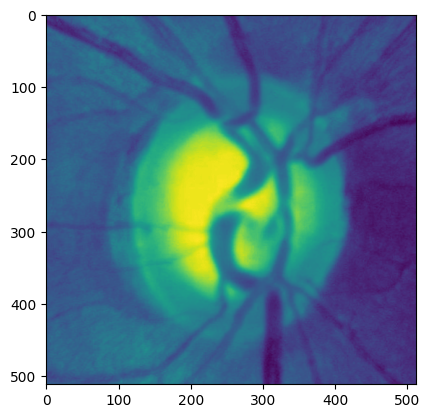

In [11]:
plt.imshow(image)

In [12]:
print(label.shape)

(512, 512, 3)


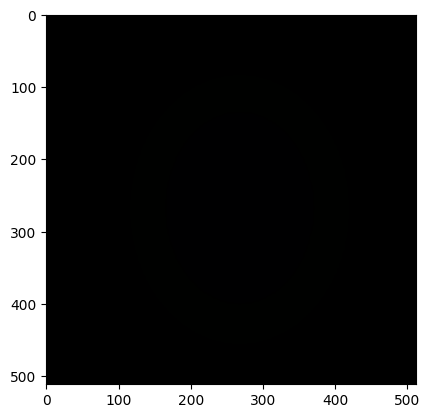

In [13]:
plt.imshow(label)

In [14]:
unique_values, counts = np.unique(label, return_counts=True)
for value, count in zip(unique_values, counts):
    print(str(value) +":    "+str(count))

0:    697099
1:    89333


In [15]:
label.shape

(512, 512, 3)

In [16]:
unique_values, counts = np.unique(label, return_counts=True)
for value, count in zip(unique_values, counts):
    print(str(value) +":    "+str(count))

0:    697099
1:    89333


In [17]:
class CustomSegmentationDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(self.image_paths))
        
    def __getitem__(self, idx):
        image_path = os.listdir(self.image_paths)[idx]
        label_path = os.listdir(self.label_paths)[idx]
        
        image = cv2.imread(self.image_paths + "\/" + image_path)
        #image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        label = cv2.imread(self.label_paths + "\/" +label_path)
        #label = label[:,:,0]
        zero = label[:,:,0]
        disk = label[:,:,1]
        cup = label[:,:,2]
        zero[zero == 0] = 255
        zero[zero == 1] = 0
        zero[zero == 2] = 0
        disk[disk ==1] = 255
        disk[disk ==2] = 0
        cup[cup==1] =0
        cup[cup==2] = 128
        label[:,:,0] = zero
        label[:,:,1] = disk
        label[:,:,2] = cup
        if self.transform:
            image = Image.fromarray(image) 
            image = self.transform(image)#.to(device)
            #image = image/255

            label = Image.fromarray(label)
            label = self.transform(label)
        
        return image, label

In [18]:
data_transform = transforms.Compose([
    transforms.Resize((256, 256), antialias=True),
    transforms.ToTensor(),
])

In [19]:
train_dataset = CustomSegmentationDataset(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Images_Cropped\Train', r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Masks_Cropped\Train', data_transform)
valid_dataset = CustomSegmentationDataset(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Images_Cropped\Valid', r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Masks_Cropped\Valid', data_transform)

In [20]:
batchSize = 64
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize, shuffle=True, generator=torch.Generator(device='cuda'), num_workers=0, 
    pin_memory=True)
valid_data = torch.utils.data.DataLoader(valid_dataset, batch_size=batchSize, shuffle=True, generator=torch.Generator(device='cuda'), num_workers=0, 
    pin_memory=True)

In [21]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, padding=0, stride=1, dilation=1, bias=False):
        super(ConvBlock, self).__init__()
        padding = (kernel_size + (kernel_size - 1) * (dilation - 1)) // 2
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.convInst = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias),
            nn.ReLU()
        )

    def forward(self, x):
        if x.shape[-2] == 1 and x.shape[-1]==1:
             out = self.convInst(x)
        else:
            out = self.conv(x)
        return out
    
    def upsample(input, size=None, scale_factor=None, align_corners=False):
        out = F.interpolate(input, size=size, scale_factor=scale_factor, mode='bilinear', align_corners=align_corners)
        return out


In [22]:
class PyramidPooling(nn.Module):
    def __init__(self, in_channels):
        super(PyramidPooling, self).__init__()
        self.pooling_size = [1, 2, 3, 6]
        self.channels = in_channels // 4
        
        self.pool1 = nn.Sequential(
            nn.AdaptiveAvgPool2d(self.pooling_size[0]),
            ConvBlock(in_channels, self.channels, kernel_size=1),
        )

        self.pool2 = nn.Sequential(
            nn.AdaptiveAvgPool2d(self.pooling_size[1]),
            ConvBlock(in_channels, self.channels, kernel_size=1),
        )

        self.pool3 = nn.Sequential(
            nn.AdaptiveAvgPool2d(self.pooling_size[2]),
            ConvBlock(in_channels, self.channels, kernel_size=1),
        )

        self.pool4 = nn.Sequential(
            nn.AdaptiveAvgPool2d(self.pooling_size[3]),
            ConvBlock(in_channels, self.channels, kernel_size=1),
        )

    def forward(self, x):
        out1 = self.pool1(x)
        out1 = upsample(out1, size=x.size()[-2:])

        out2 = self.pool2(x)
        out2 = upsample(out2, size=x.size()[-2:])

        out3 = self.pool3(x)
        out3 = upsample(out3, size=x.size()[-2:])

        out4 = self.pool4(x)
        out4 = upsample(out4, size=x.size()[-2:])

        out = torch.cat([x, out1, out2, out3, out4], dim=1)
        return out


In [23]:
def upsample(input, size=None, scale_factor=None, align_corners=False):
    out = F.interpolate(input, size=size, scale_factor=scale_factor, mode='bilinear', align_corners=align_corners)
    return out

In [24]:
class PSPNet(nn.Module):
    def __init__(self, n_classes=64, n_out_classes=3):
        super(PSPNet, self).__init__()
        self.out_channels = 512  #2048

        self.backbone = resnet.resnet34(pretrained=True)
        self.stem = nn.Sequential(
            *list(self.backbone.children())[:4],
        )
        self.block1 = self.backbone.layer1
        self.block2 = self.backbone.layer2
        self.block3 = self.backbone.layer3
        self.block4 = self.backbone.layer4
        #self.low_level_features_conv = ConvBlock(64, 64, kernel_size=3)

        self.depth = self.out_channels // 4
        self.pyramid_pooling = PyramidPooling(self.out_channels)
        
        self.decoder = nn.Sequential(
            ConvBlock(self.out_channels * 2, self.depth, kernel_size=3),
            nn.Dropout(0.1),
            nn.Conv2d(self.depth, n_out_classes, kernel_size=1),
        )

        self.aux = nn.Sequential(
            ConvBlock(self.out_channels // 2, self.depth // 2, kernel_size=3),
            nn.Dropout(0.1),
            nn.Conv2d(self.depth // 2, n_classes, kernel_size=1),
        )

        self.sigm = nn.Sigmoid()
        self.sftmax = nn.Softmax()
        
    def forward(self, x, label=None):
        out = self.stem(x)
        out1 = self.block1(out)
        out2 = self.block2(out1)
        out3 = self.block3(out2)
        out4 = self.block4(out3)
        
        out = self.pyramid_pooling(out4)
        out = self.decoder(out)
        out = upsample(out, size=x.size()[-2:])
        out = upsample(out, size=x.shape[-2:], align_corners=True)
        #out = self.sftmax(out)
        return out

In [25]:
num_epochs = 100  #25 epoch good
best_val_loss = float('inf')
early_stop_patience = 5
learning_rate = 0.0001
weight_decay = 0.001

In [26]:
class DiceLoss(torch.nn.Module):
    def __init__(self, num_classes):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes

    def dice_coefficient(self, prediction, target, class_index):
        smooth = 1.0
        intersection = torch.sum((prediction == class_index) & (target == class_index))
        union = torch.sum(prediction == class_index) + torch.sum(target == class_index)
        dice = (2. * intersection + smooth) / (union + smooth)
        return dice

    def forward(self, prediction, target):
        total_loss = 0.0
        for class_index in range(1, self.num_classes):  # Assuming background is class 0
            dice = self.dice_coefficient(prediction, target, class_index)
            loss = 1 - dice
            total_loss += loss
        return total_loss / (self.num_classes - 1)  # Average across classes

In [27]:
model = PSPNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 
criterion = torch.nn.CrossEntropyLoss()
print(model)

C:\Users\samko\Desktop\Files\UNI\DP\LinkNet\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\samko\Desktop\Files\UNI\DP\LinkNet\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'CrossEntropyLoss' is not defined

In [ ]:
train_loss_list = []
valid_loss_list = [] 
total_accuracy = 0.0
total_iou = 0.0
total_samples = 0
success_epoch = 0
clip_value = 1

for epoch in range(num_epochs): 
    start_time = time.time()
    print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
    
    success_epoch+=1
    train_loss = 0
    valid_loss = 0
    #Iterating over the training dataset in batches 
    model.train() 
    for images, labels in train_data: 
        #Extracting images and target labels for the batch being iterated 
        images = images.to(device) 
        labels= labels.to(device) 
        #Calculating the model output and the cross entropy loss 
        outputs = model.forward(images) 
        # outputs = (outputs>0.5).float()
        # labels = (labels==1).float()
        # outputs.requires_grad = True
        
        # outputs = tf.where(outputs.cpu().detach().numpy() > 0.5, 1, 0)
        # labels =  tf.where(labels.cpu().detach().numpy() == 1, 1, 0)
        # with device:
        #     outputs = tf.identity(outputs)
        #     labels = tf.identity(labels)
        loss = criterion(outputs, labels) 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        
        train_loss += loss.item() 
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_data):
            images = images.to(device) 
            labels = labels.to(device)
            
            outputs = model(images) 

            # outputs = (outputs>0.5).float()
            # labels = (labels==1).float()
            # outputs.requires_grad = True
            
            # outputs = tf.where(outputs.cpu().detach().numpy() > 0.5, 1, 0)
            # labels =  tf.where(labels.cpu().detach().numpy() == 1, 1, 0)
            # with device:
            #     outputs = tf.identity(outputs)
            #     labels = tf.identity(labels)
            
            loss = criterion(outputs, labels)
        
            valid_loss += loss.item() 

    
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= early_stop_patience:
            break
    #Printing loss for each epoch 
    train_loss_list.append(train_loss/len(train_data))
    valid_loss_list.append(valid_loss/len(valid_data)) 
    print(f"Time:{time.time() - start_time} sec   Training loss = {train_loss_list[-1]} Validation loss = {valid_loss_list[-1]}")# IoU_train = {average_iou_train}  Iou_valid = {average_iou_valid} Accuracy_train = {average_accuracy_train} Accuracy_valid = {average_accuracy_valid}") #  DICE: {dice_coef}")      

In [ ]:
# outputs = (outputs > 0.5).int()
# output = outputs[60,:,:,:]
# label = labels[60,:,:,:]

# output = output.to("cpu").detach().numpy().transpose(1,2,0)
# label = label.to("cpu").detach().numpy().transpose(1,2,0)



In [ ]:
# unique_values, counts = np.unique(output, return_counts=True)
# for value, count in zip(unique_values, counts):
#     print(str(value) +":    "+str(count))

In [ ]:
plt.plot(range(1,success_epoch), train_loss_list, label="Training loss") 
plt.plot(range(1,success_epoch), valid_loss_list, label="Validation loss") 
plt.xlabel("Number of epochs") 
plt.ylabel("loss") 
plt.legend()

In [ ]:
# plt.plot(range(1,success_epoch+1), train_loss_list, label="Training loss") 
# plt.plot(range(1,success_epoch+1), valid_loss_list, label="Validation loss") 
# plt.xlabel("Number of epochs") 
# plt.ylabel("loss") 
# plt.legend()

In [ ]:
folder = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34'

test_folder = folder + '\Test'
test_gt_folder = folder + '\Test_gt'
test_results_folder = folder + '\Test_results_cup_128'

test_files = os.listdir(test_folder)
test_gt_files = os.listdir(test_gt_folder)

In [ ]:
images_test = []
for file in test_files:
    images_test.append(test_folder + "\/" + file)

In [ ]:
threshold = 0.5
model.eval()
with torch.no_grad():
    for image in images_test:
        filename = os.path.basename(image)
        #cropped_image = crop_image(np.array(Image.open(image)), 20, 40)
        #image = Image.fromarray(cropped_image)
        image = Image.open(image)
        orig_image = image
        image = image.resize((256, 256), resample=Image.NEAREST)
        #image = image.convert('L')
        image = transform(image)
        image = image.unsqueeze(0)
        image = image.to(device) 
        output = model(image)

        output = output.detach().cpu().numpy()[0]
        #output = output * 10
        output = (output > threshold)
        print(output.shape)
        output = np.transpose(output, (1, 2, 0))
        
        plt.imshow(output[:,:,0])

        break
        
        # output_dict = {"mask": output}
        # savemat(test_results_folder + "\/" + filename.strip(".jpg") + ".mat", output_dict)

In [ ]:
plt.imshow(np.transpose(image.squeeze().to('cpu').numpy(), (1, 2, 0)))

In [ ]:
plt.imshow(Image.open(test_gt_folder + "\/" + test_gt_files[-1]))

In [ ]:
unique_values, counts = np.unique(output, return_counts=True)
for value, count in zip(unique_values, counts):
    print(str(value) +":    "+str(count))

In [ ]:
np.max(output)

In [ ]:
#torch.save(model, r''+folder_path+r'\SaveModels\PSPNet_Cup\PSPNet_resnet34_pretrained_combined_128.pt')

In [ ]:
#torch.save(model.state_dict(), r''+folder_path+r'\SaveModels\PSPNet_Cup\PSPNet_resnet34_pretrained_combined_state_dict.pt')

In [ ]:
image = Image.open(test_folder + "\/" + "633.jpg")
#label = loadmat(test_gt_folder + "\/" + "646.mat").get("mask")
label = Image.open(test_gt_folder + "\/" + "633.png")
orig_image = image

In [ ]:
plt.imshow(image)

In [ ]:
plt.imshow(label)

In [ ]:
threshold = 0.5
model.eval()
image = image.resize((256, 256), resample=Image.NEAREST)
#image = image.convert('L')
image = transform(image)
image = image.unsqueeze(0)

image = image.to(device) 
output = model(image)

output = output.detach().cpu().numpy()[0]
#output = output * 10
output = (output > threshold)
print(output.shape)
output = np.transpose(output, (1, 2, 0))

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(2,4,1)  #2,4,1
plt.imshow(label)  
plt.subplot(1,4,2)   #
plt.imshow(output[:,:,0])
plt.subplot(2,4,2)   #2,4,2
plt.imshow(output[:,:,1])
plt.subplot(1,4,1)   #1,4,1
plt.imshow(output[:,:,2])
print('True positive: GREEN')
print('True negative: BLUE')
print('False positive: RED')
print('False negative: YELLOW')